In [1]:
import numpy as np

In [48]:
import warnings
from pandas.errors import SettingWithCopyWarning  # <- import the class

warnings.simplefilter('ignore', category=FutureWarning)
warnings.simplefilter('ignore', category=SettingWithCopyWarning)



In [3]:
import pandas as pd

# Load the cleaned dataset
trips = pd.read_parquet("final_cleaned_trips_20250826.parquet")

# Confirm shape and columns
print(trips.shape)
trips.head()


(12836253, 25)


,Trip ID,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Community Area,Dropoff Community Area,Fare,Tip,Additional Charges,...,pct_hispanic,pct_nonwhite,pickup_Hardship_index,dropoff_pct_low_income,dropoff_pct_black,dropoff_pct_hispanic,dropoff_pct_nonwhite,dropoff_Hardship_index,start_hour,day_of_week
0,33b1614c9a4a079385015c9b0a5959c36e465ab5,2024-01-01,2024-01-01 00:30:00,1772.0,20.3,7,<NA>,32.5,0.0,1.23,...,6.886107,20.927385,2.0,NaN,NaN,NaN,NaN,NaN,0,Monday
1,00271a15c3a829e9704215542a86c61a8acc3104,2024-01-01,2024-01-01 00:15:00,863.0,7.8,41,28,15.0,0.0,1.23,...,7.313631,55.151087,14.0,25.041848,24.627505,10.370200,56.735506,15.0,0,Monday
2,003cac86fb7f87ff06ec5cb20c0461f383ed2254,2024-01-01,2024-01-01 00:00:00,787.0,5.2,34,24,12.5,0.0,3.83,...,4.296905,83.070956,82.0,13.096606,6.985298,19.778377,36.954183,10.0,0,Monday
3,00776c33df35d6ca0c98119c86f055c2c6e8dfe7,2024-01-01,2024-01-01 00:15:00,262.0,0.8,8,7,5.0,0.0,2.31,...,7.272330,31.574180,1.0,5.873386,3.678283,6.886107,20.927385,2.0,0,Monday
4,009a42711519a94c300975076ad7932a2b8c8906,2024-01-01,2024-01-01 00:15:00,969.0,3.9,40,45,15.0,0.0,1.23,...,1.383271,98.139460,88.0,37.670949,94.016013,0.505689,99.715550,41.0,0,Monday


In [5]:
trips1=trips.copy()

In [27]:
trips1[['Trip Miles', 'Trip Seconds', 'Fare', 'Tip', 'Trip Total']].describe()

,Trip Miles,Trip Seconds,Fare,Tip,Trip Total
count,1.283625e+07,1.283625e+07,1.283074e+07,1.283074e+07,1.283074e+07
mean,6.021626e+00,9.979489e+02,1.567592e+01,1.107208e+00,2.079450e+01
std,6.814695e+00,6.975744e+02,1.167602e+01,2.588122e+00,1.491243e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.800000e+00,5.060000e+02,7.500000e+00,0.000000e+00,1.157000e+01
50%,3.600000e+00,8.190000e+02,1.250000e+01,0.000000e+00,1.623000e+01
75%,7.700000e+00,1.297000e+03,2.000000e+01,0.000000e+00,2.391000e+01
max,3.841000e+02,4.773000e+04,5.875000e+02,1.080000e+02,6.447900e+02


### Creating 'fare_per_mile' and 'fare_per_minute' columns

In [7]:
# Replace infinite values safely
trips1['fare_per_mile'] = trips1['Trip Total'] / trips1['Trip Miles']
trips1['fare_per_minute'] = trips1['Trip Total'] / (trips1['Trip Seconds'] / 60)

trips1['fare_per_mile'] = trips1['fare_per_mile'].replace([np.inf, -np.inf], np.nan)
trips1['fare_per_minute'] = trips1['fare_per_minute'].replace([np.inf, -np.inf], np.nan)




#### Correlation between fares and trip miles

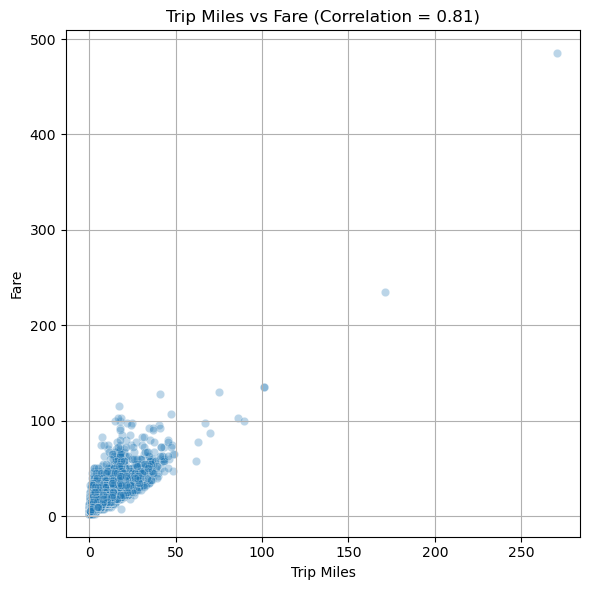

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter out zero or missing values
filtered = trips1[(trips1['Trip Miles'] > 0) & (trips1['Fare'] > 0)]

# Calculate correlation
correlation = filtered['Trip Miles'].corr(filtered['Fare'])

# Scatter plot (sampling to avoid overplotting)
plt.figure(figsize=(6, 6))
sns.scatterplot(
    data=filtered.sample(10000, random_state=42), 
    x='Trip Miles', 
    y='Fare', 
    alpha=0.3
)
plt.title(f"Trip Miles vs Fare (Correlation = {correlation:.2f})")
plt.xlabel("Trip Miles")
plt.ylabel("Fare")
plt.grid(True)
plt.tight_layout()
plt.show()


#### Checking for Outliers

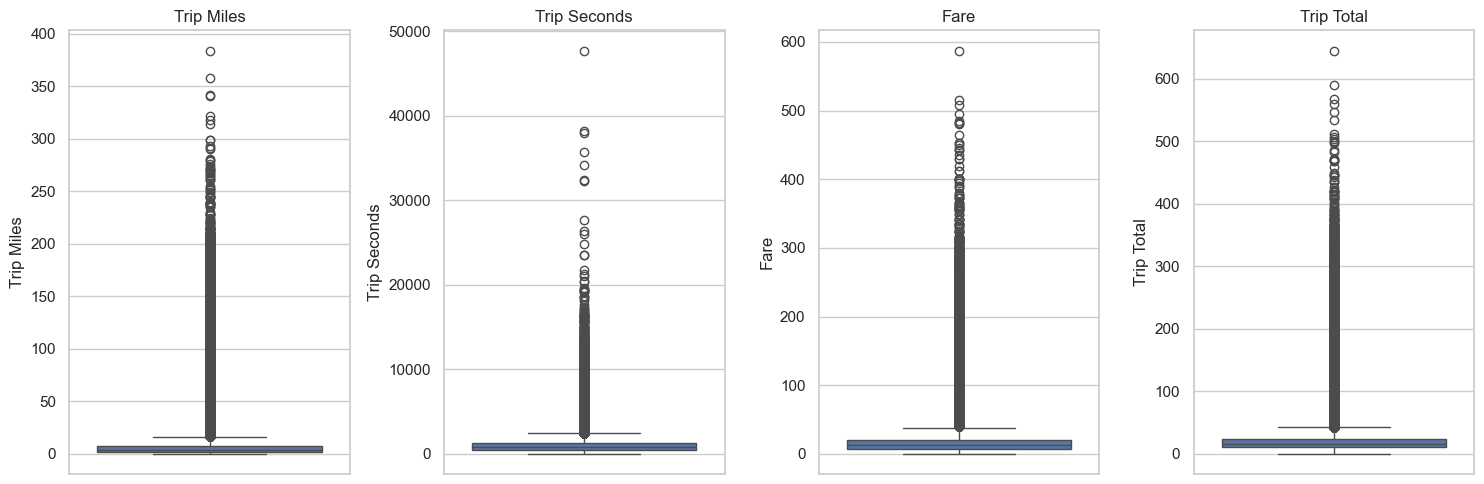

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up for larger plots
sns.set(style="whitegrid")
plt.figure(figsize=(15, 5))

# Boxplots to visualize outliers
columns_to_plot = ['Trip Miles', 'Trip Seconds', 'Fare', 'Trip Total']
for i, col in enumerate(columns_to_plot):
    plt.subplot(1, 4, i+1)
    sns.boxplot(data=trips1, y=col)
    plt.title(col)

plt.tight_layout()
plt.show()


In [53]:
def detect_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    upper_bound = Q3 + 1.5 * IQR
    return df[df[col] > upper_bound], upper_bound

outlier_summary = {}
for col in ['Trip Miles', 'Trip Seconds', 'Fare', 'Trip Total']:
    outliers, upper = detect_outliers(trips1, col)
    outlier_summary[col] = {
        'Outlier Count': len(outliers),
        'Outlier %': len(outliers) / len(trips1) * 100,
        'Upper Bound': round(upper, 2)
    }

pd.DataFrame(outlier_summary).T


,Outlier Count,Outlier %,Upper Bound
Trip Miles,1055198.0,8.220452,16.55
Trip Seconds,529066.0,4.121655,2483.50
Fare,608299.0,4.738914,38.75
Trip Total,1075152.0,8.375902,42.42


In [18]:
agg = trips1.groupby(['Pickup Community Area', 'start_hour', 'day_of_week']).agg({
    'Trip ID': 'count',
    'Trip Miles': 'median',
    'Trip Seconds': 'median',
    'Fare': 'mean',
    'Tip': 'mean',
    'Trip Total': 'mean',
    'fare_per_mile': 'mean',
    'fare_per_minute': 'mean',
    'pct_low_income': 'first',
    'pct_nonwhite': 'first',
    'pct_black': 'first',
    'pct_hispanic': 'first'
}).reset_index().rename(columns={'Trip ID': 'trip_count'})


In [17]:
agg

,Pickup Community Area,start_hour,day_of_week,trip_count,Trip Miles,Trip Seconds,Fare,Tip,Trip Total,fare_per_mile,fare_per_minute,pct_low_income,pct_nonwhite,pct_black,pct_hispanic
0,1,0,Friday,512,3.30,676.5,11.640625,0.738281,14.986270,5.367273,1.462758,30.974086,56.444545,25.582576,19.934548
1,1,0,Monday,516,3.25,667.5,13.202519,1.160853,17.008391,5.629090,1.561971,30.974086,56.444545,25.582576,19.934548
2,1,0,Saturday,1022,4.00,762.0,12.235553,1.143976,16.461048,5.306536,1.444381,30.974086,56.444545,25.582576,19.934548
3,1,0,Sunday,1133,4.20,784.0,12.128647,1.145004,16.139469,5.082449,1.401407,30.974086,56.444545,25.582576,19.934548
4,1,0,Thursday,398,2.60,572.5,10.445980,0.904523,13.576457,5.057832,1.360118,30.974086,56.444545,25.582576,19.934548
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12931,77,23,Saturday,2564,3.60,715.5,13.032579,1.110027,17.008283,5.318449,1.439183,21.484283,45.373178,11.970348,16.333923
12932,77,23,Sunday,903,2.80,580.0,10.445736,0.769657,13.743765,4.740342,1.338173,21.484283,45.373178,11.970348,16.333923
12933,77,23,Thursday,887,2.90,602.0,10.663842,0.883616,14.013672,5.157818,1.377526,21.484283,45.373178,11.970348,16.333923
12934,77,23,Tuesday,563,2.60,557.0,10.324156,0.866785,13.402504,4.933230,1.376319,21.484283,45.373178,11.970348,16.333923


### 1. Do high-income areas have cheaper fares (per mile or per minute)?
#### Insight Goal: Test for systemic underpricing in wealthier areas.

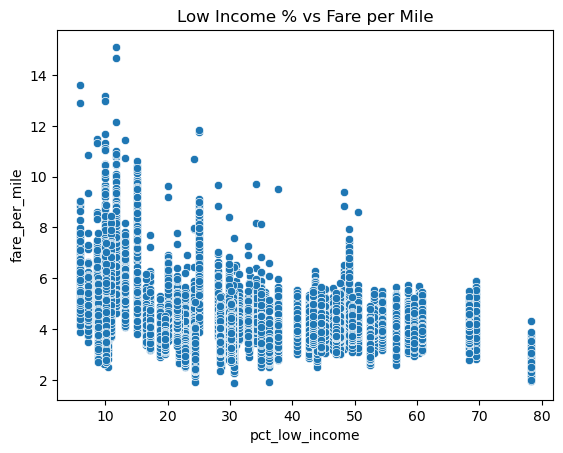

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(data=agg, x='pct_low_income', y='fare_per_mile')
plt.title("Low Income % vs Fare per Mile")
plt.show()


In [22]:
trips1[['fare_per_mile', 'pct_low_income']].corr()


,fare_per_mile,pct_low_income
fare_per_mile,1.000000,-0.195769
pct_low_income,-0.195769,1.000000


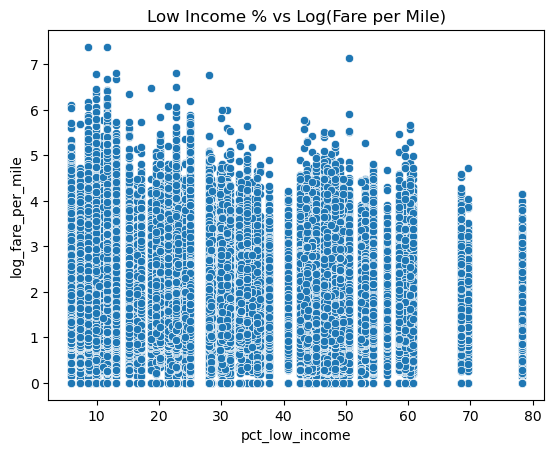

In [24]:

trips1['log_fare_per_mile'] = np.log(trips1['fare_per_mile'] + 1)

sns.scatterplot(data=trips1, x='pct_low_income', y='log_fare_per_mile')
plt.title("Low Income % vs Log(Fare per Mile)")
plt.show()


#### Check if trips from low pct_low_income areas tend to be shorter:

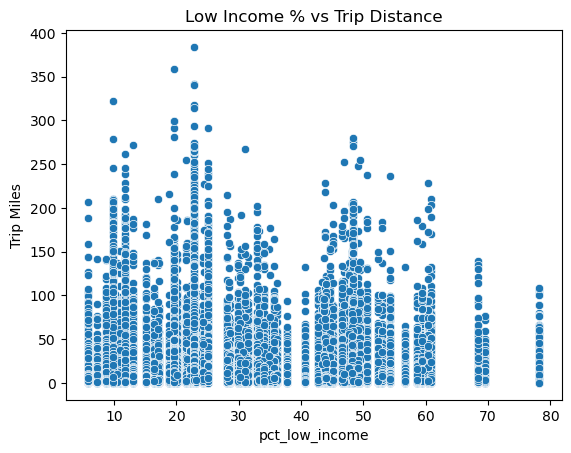

In [26]:
sns.scatterplot(data=trips1, x='pct_low_income', y='Trip Miles')
plt.title("Low Income % vs Trip Distance")
plt.show()


In [29]:
fare_mile_by_area = trips1.groupby('Pickup Community Area')['fare_per_mile'].mean().sort_values(ascending=False)
print(fare_mile_by_area.head(10))


Pickup Community Area
8     8.353358
32    8.074963
41    7.222339
28    7.051835
7     6.589059
33    6.321077
24    6.136554
6     6.095306
42    5.502217
5     5.369153
Name: fare_per_mile, dtype: float64


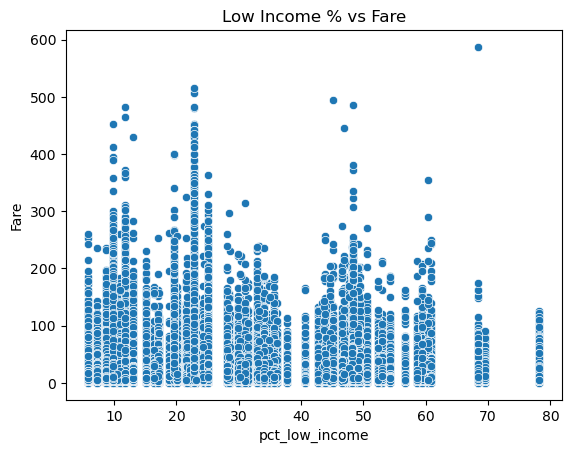

In [33]:
sns.scatterplot(data=trips1, x='pct_low_income', y='Fare')
plt.title("Low Income % vs Fare")
plt.show()


In [14]:
trips1['income_bin'] = pd.cut(trips1['pct_low_income'], bins=[0,10,20,30,40,50,60,70,80])
avg_fare_by_income = trips1.groupby('income_bin')['Fare'].mean().reset_index()


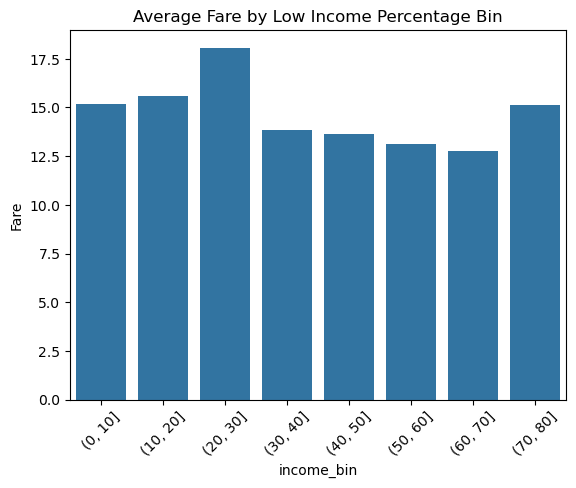

In [37]:

sns.barplot(data=avg_fare_by_income, x='income_bin', y='Fare')
plt.xticks(rotation=45)
plt.title('Average Fare by Low Income Percentage Bin')
plt.show()


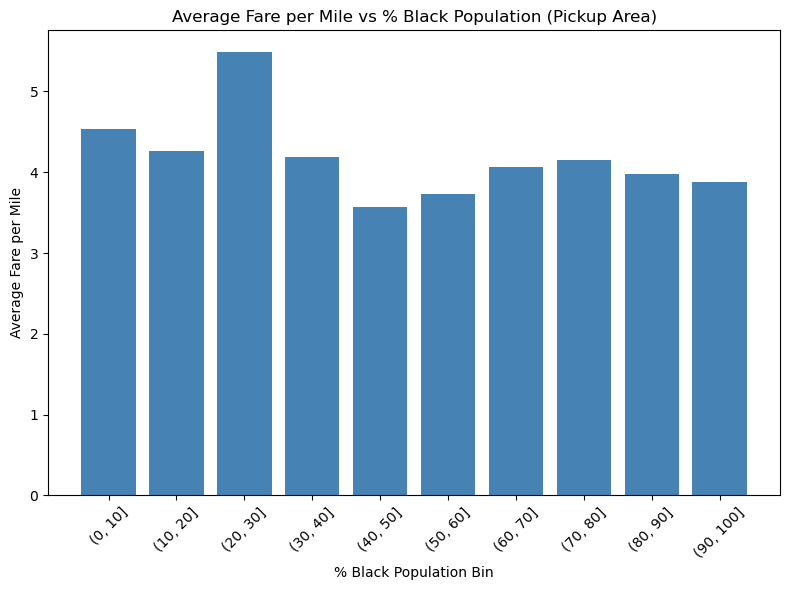

In [22]:

# Bin % black population
agg['black_bin'] = pd.cut(agg['pct_black'], bins=range(0, 110, 10))

# Group by bin and calculate average fare per mile
black_fare = agg.groupby('black_bin')['fare_per_mile'].mean().reset_index()

# Plotting
plt.figure(figsize=(8, 6))
plt.bar(black_fare['black_bin'].astype(str), black_fare['fare_per_mile'], color='steelblue')
plt.xticks(rotation=45)
plt.xlabel('% Black Population Bin')
plt.ylabel('Average Fare per Mile')
plt.title('Average Fare per Mile vs % Black Population (Pickup Area)')
plt.tight_layout()
plt.show()


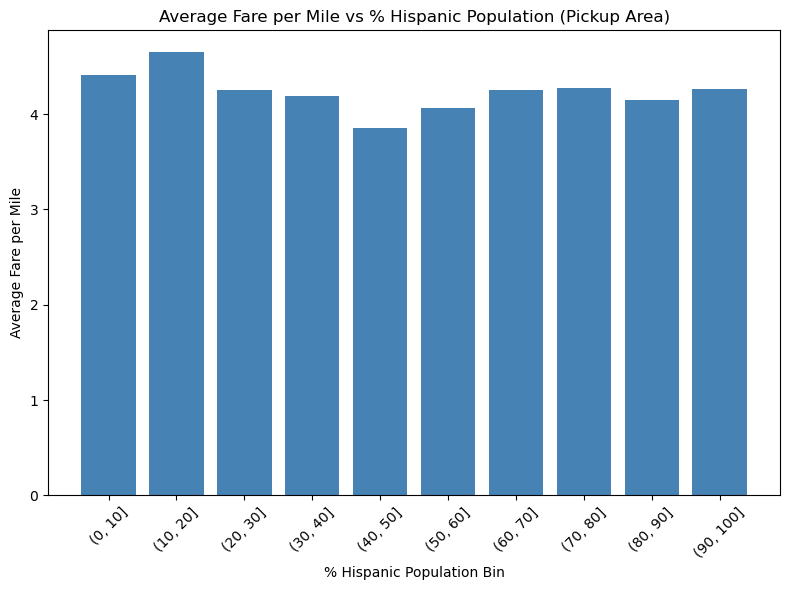

In [24]:
agg['hispanic_bin'] = pd.cut(agg['pct_hispanic'], bins=range(0, 110, 10))
hispanic_fare = agg.groupby('hispanic_bin')['fare_per_mile'].mean().reset_index()
# Plotting
plt.figure(figsize=(8, 6))
plt.bar(hispanic_fare['hispanic_bin'].astype(str), hispanic_fare['fare_per_mile'], color='steelblue')
plt.xticks(rotation=45)
plt.xlabel('% Hispanic Population Bin')
plt.ylabel('Average Fare per Mile')
plt.title('Average Fare per Mile vs % Hispanic Population (Pickup Area)')
plt.tight_layout()
plt.show()

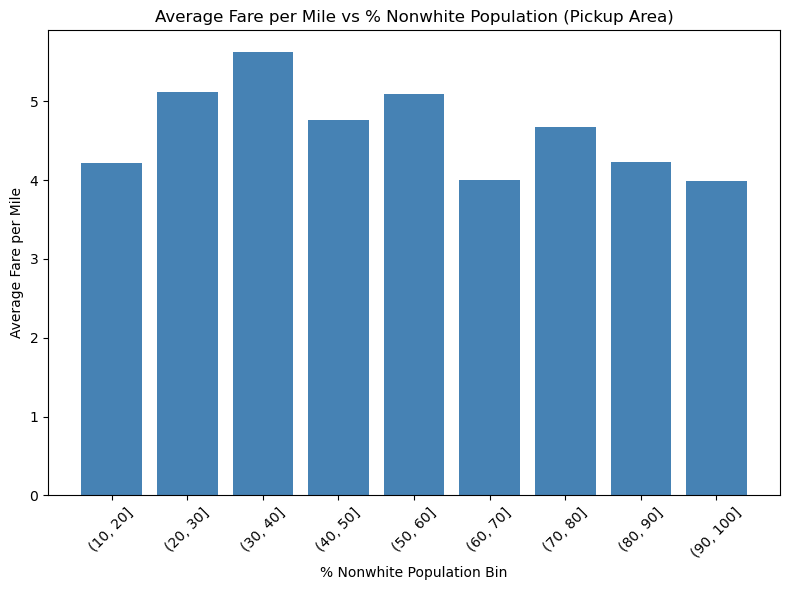

In [26]:
agg['nonwhite_bin'] = pd.cut(agg['pct_nonwhite'], bins=range(0, 110, 10))
nonwhite_fare = agg.groupby('nonwhite_bin')['fare_per_mile'].mean().reset_index()
# Plotting
plt.figure(figsize=(8, 6))
plt.bar(nonwhite_fare['nonwhite_bin'].astype(str), nonwhite_fare['fare_per_mile'], color='steelblue')
plt.xticks(rotation=45)
plt.xlabel('% Nonwhite Population Bin')
plt.ylabel('Average Fare per Mile')
plt.title('Average Fare per Mile vs % Nonwhite Population (Pickup Area)')
plt.tight_layout()
plt.show()

#### Finding out peak hours from data

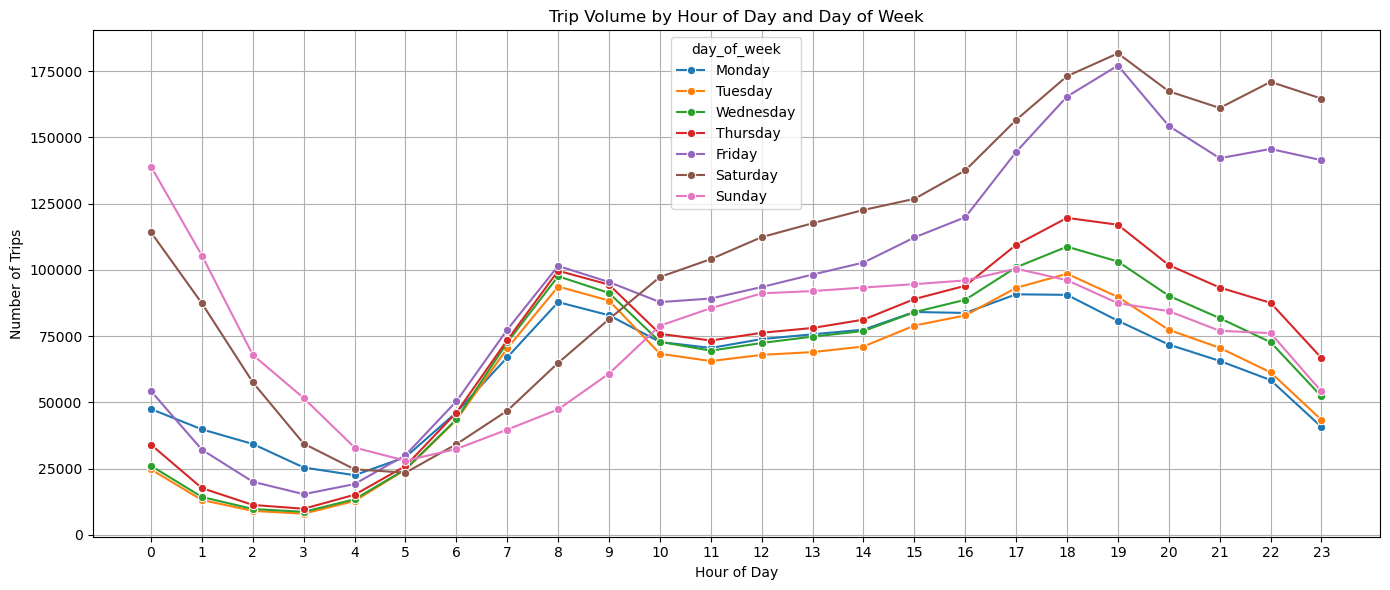

In [48]:
# Count trips by hour and weekday
hourly_counts = trips1.groupby(['day_of_week', 'start_hour'])['Trip ID'].count().reset_index()
hourly_counts.rename(columns={'Trip ID': 'trip_count'}, inplace=True)

# Sort days in proper order
ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
hourly_counts['day_of_week'] = pd.Categorical(hourly_counts['day_of_week'], categories=ordered_days, ordered=True)

# Plot
plt.figure(figsize=(14, 6))
sns.lineplot(data=hourly_counts, x='start_hour', y='trip_count', hue='day_of_week', marker='o')
plt.title('Trip Volume by Hour of Day and Day of Week')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Trips')
plt.xticks(range(0, 24))
plt.grid(True)
plt.tight_layout()
plt.show()

In [50]:
def label_time_of_day(hour):
    if 7 <= hour <= 9:
        return 'Morning Rush'
    elif 16 <= hour <= 19:
        return 'Evening Rush'
    elif 10 <= hour <= 15:
        return 'Midday'
    elif 20 <= hour <= 23:
        return 'Night'
    elif 0 <= hour <= 6:
        return 'Late Night / Early Morning'
    else:
        return 'Other'

agg['time_category'] = agg['start_hour'].apply(label_time_of_day)


In [11]:


# Aggregate pickups
pickup_stats = trips1.groupby("Pickup Community Area").agg(
    n_pickups=("Trip ID", "count"),
    avg_fare=("Fare", "mean")
).reset_index()

# Aggregate dropoffs
dropoff_stats = trips1.groupby("Dropoff Community Area").agg(
    n_dropoffs=("Trip ID", "count"),
    avg_fare=("Fare", "mean")
).reset_index()

# Merge if you want combined frequency (pickups + dropoffs)
combined = pickup_stats.merge(
    dropoff_stats, 
    left_on="Pickup Community Area", 
    right_on="Dropoff Community Area", 
    how="outer"
)

combined["total_trips"] = combined["n_pickups"].fillna(0) + combined["n_dropoffs"].fillna(0)
combined["avg_fare"] = combined[["avg_fare_x", "avg_fare_y"]].mean(axis=1)


In [13]:
combined

,Pickup Community Area,n_pickups,avg_fare_x,Dropoff Community Area,n_dropoffs,avg_fare_y,total_trips,avg_fare
0,1,167858,14.308346,1,130348,14.554677,298206,14.431512
1,2,123456,13.003150,2,88630,13.013041,212086,13.008095
2,3,280286,14.179735,3,250667,13.380882,530953,13.780309
3,4,135550,13.968850,4,124696,13.717102,260246,13.842976
4,5,140920,14.642254,5,132175,13.839303,273095,14.240778
...,...,...,...,...,...,...,...,...
72,73,55210,13.681967,73,43743,12.721644,98953,13.201806
73,74,14121,15.131197,74,8114,17.461154,22235,16.296176
74,75,43693,14.251311,75,33275,14.078200,76968,14.164755
75,76,607524,34.748375,76,458724,35.487787,1066248,35.118081


#### Correlation between freq of trips and fares on pick-up/drop-off location

In [15]:
corr = combined["total_trips"].corr(combined["avg_fare"])
print("Correlation between trip frequency and avg fare:", corr)

Correlation between trip frequency and avg fare: 0.16130955077539474


In [17]:
import statsmodels.api as sm

X = sm.add_constant(combined["total_trips"])
y = combined["avg_fare"]

model = sm.OLS(y, X).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:               avg_fare   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     2.004
Date:                Mon, 25 Aug 2025   Prob (F-statistic):              0.161
Time:                        19:25:29   Log-Likelihood:                -196.00
No. Observations:                  77   AIC:                             396.0
Df Residuals:                      75   BIC:                             400.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          13.8304      0.406     34.087      

In [19]:

combined["log_total_trips"] = np.log1p(combined["total_trips"])
X = sm.add_constant(combined["log_total_trips"])
y = combined["avg_fare"]

model_log = sm.OLS(y, X).fit()
print(model_log.summary())

                            OLS Regression Results                            
Dep. Variable:               avg_fare   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     1.748
Date:                Mon, 25 Aug 2025   Prob (F-statistic):              0.190
Time:                        19:31:12   Log-Likelihood:                -196.13
No. Observations:                  77   AIC:                             396.3
Df Residuals:                      75   BIC:                             400.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               9.4603      3.531     

#### Multiple linear regression

In [22]:


area_stats = trips1.groupby("Pickup Community Area").agg(
    total_trips=("Trip ID", "count"),
    avg_fare=("Fare", "mean"),
    avg_miles=("Trip Miles", "mean"),
    avg_seconds=("Trip Seconds", "mean"),
    avg_additional_charges=("Additional Charges", "mean"),
    pct_low_income=("pct_low_income", "mean"),
    pct_black=("pct_black", "mean"),
    pct_hispanic=("pct_hispanic", "mean"),
    pct_nonwhite=("pct_nonwhite", "mean")
).reset_index()

# log-transform frequency
area_stats["log_total_trips"] = np.log1p(area_stats["total_trips"])


In [24]:
import statsmodels.api as sm

X = area_stats[[
    "log_total_trips", 
    "avg_miles", 
    "avg_seconds", 
    "avg_additional_charges",
    "pct_low_income", 
    "pct_black", 
    "pct_hispanic", 
    "pct_nonwhite"
]]
X = sm.add_constant(X)
y = area_stats["avg_fare"]

model_multi = sm.OLS(y, X).fit()
print(model_multi.summary())


                            OLS Regression Results                            
Dep. Variable:               avg_fare   R-squared:                       0.981
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                     429.7
Date:                Mon, 25 Aug 2025   Prob (F-statistic):           4.45e-55
Time:                        19:33:36   Log-Likelihood:                -43.318
No. Observations:                  77   AIC:                             104.6
Df Residuals:                      68   BIC:                             125.7
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -0

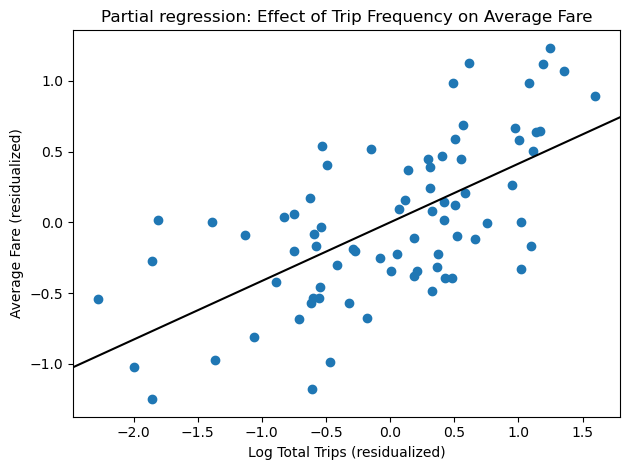

In [26]:

X = area_stats[[
    "log_total_trips", "avg_miles", "avg_seconds", "avg_additional_charges",
    "pct_low_income", "pct_black", "pct_hispanic", "pct_nonwhite"
]]
X = sm.add_constant(X)
y = area_stats["avg_fare"]

model_multi = sm.OLS(y, X).fit()

fig = sm.graphics.plot_partregress(
    endog="avg_fare",
    exog_i="log_total_trips",
    exog_others=["avg_miles","avg_seconds","avg_additional_charges",
                 "pct_low_income","pct_black","pct_hispanic","pct_nonwhite"],
    data=area_stats,
    obs_labels=False
)
plt.title("Partial regression: Effect of Trip Frequency on Average Fare")
plt.xlabel("Log Total Trips (residualized)")
plt.ylabel("Average Fare (residualized)")
plt.tight_layout()
plt.show()



In [40]:
rush_trips = trips1[
    ((trips1["start_hour"] >= 6) & (trips1["start_hour"] < 9)) | 
    ((trips1["start_hour"] >= 16) & (trips1["start_hour"] < 18))
]


### Analysis with Hardship index

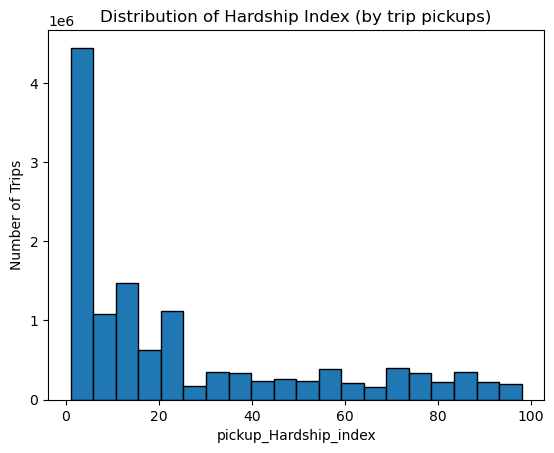

count    1.283625e+07
mean     2.581295e+01
std      2.773875e+01
min      1.000000e+00
25%      3.000000e+00
50%      1.500000e+01
75%      4.200000e+01
max      9.800000e+01
Name: pickup_Hardship_index, dtype: float64


In [15]:
import matplotlib.pyplot as plt

plt.hist(trips1["pickup_Hardship_index"], bins=20, edgecolor="k")
plt.xlabel("pickup_Hardship_index")
plt.ylabel("Number of Trips")
plt.title("Distribution of Hardship Index (by trip pickups)")
plt.show()

print(trips1["pickup_Hardship_index"].describe())


count    2.835723e+06
mean     2.854024e+01
std      2.889579e+01
min      1.000000e+00
25%      3.000000e+00
50%      1.500000e+01
75%      4.800000e+01
max      9.800000e+01
Name: pickup_Hardship_index, dtype: float64


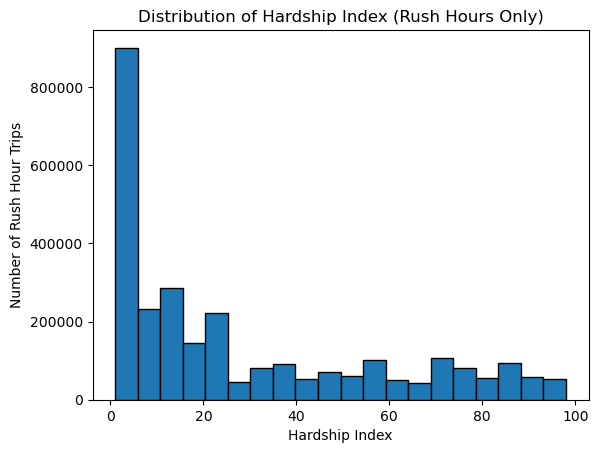

In [19]:
print(rush_trips["pickup_Hardship_index"].describe())

plt.hist(rush_trips["pickup_Hardship_index"], bins=20, edgecolor="k")
plt.xlabel("Hardship Index")
plt.ylabel("Number of Rush Hour Trips")
plt.title("Distribution of Hardship Index (Rush Hours Only)")
plt.show()


hardship_bucket
Q1    15.336806
Q2    14.841291
Q3    19.548019
Q4    13.498358
Name: Fare, dtype: float64


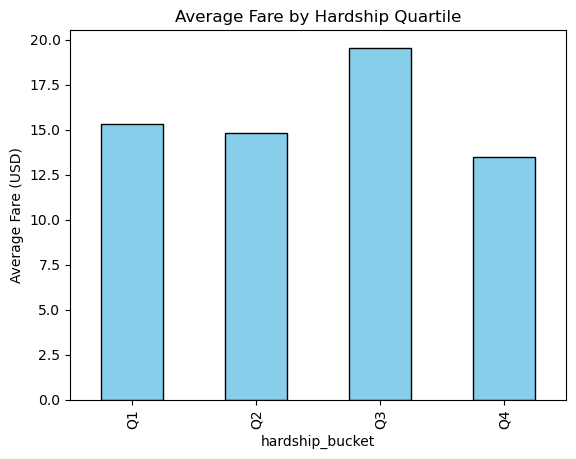

In [28]:
import pandas as pd

# make quartile buckets
trips1["hardship_bucket"] = pd.qcut(
    trips1["pickup_Hardship_index"], 
    4, 
    labels=["Q1","Q2","Q3","Q4"]
)

# group by the new buckets
fare_by_hardship = trips1.groupby("hardship_bucket")["Fare"].mean()
print(fare_by_hardship)

# plot
fare_by_hardship.plot(kind="bar", color="skyblue", edgecolor="k")
plt.ylabel("Average Fare (USD)")
plt.title("Average Fare by Hardship Quartile")
plt.show()



hardship_bucket
Q1    17.020652
Q2    16.283858
Q3    19.442348
Q4    14.602513
Name: Fare, dtype: float64


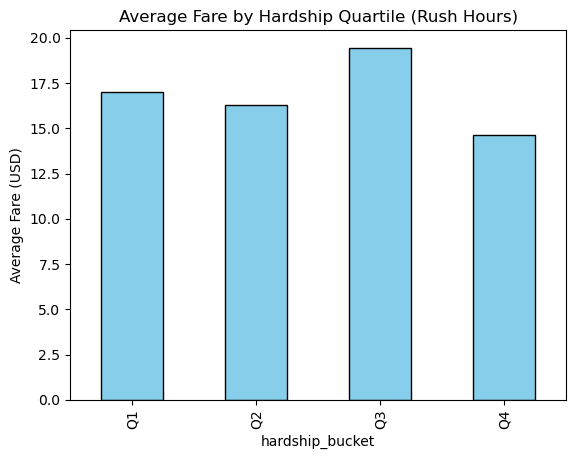

In [50]:

rush_trips = rush_trips.copy()


rush_trips["hardship_bucket"] = pd.qcut(
    rush_trips["pickup_Hardship_index"], 
    4, 
    labels=["Q1","Q2","Q3","Q4"]
)

# Group by hardship and calculate average fare
fare_by_hardship_rush = rush_trips.groupby("hardship_bucket")["Fare"].mean()
print(fare_by_hardship_rush)


fare_by_hardship_rush.plot(kind="bar", color="skyblue", edgecolor="k")
plt.ylabel("Average Fare (USD)")
plt.title("Average Fare by Hardship Quartile (Rush Hours)")
plt.show()


=== Trip volume by hardship (ALL TIMES) ===


,trips,percent
hardship_bucket,,
Q1,3602568,28.07
Q2,3385537,26.37
Q3,2774296,21.61
Q4,3073852,23.95



=== Trip volume by hardship (RUSH HOURS 6–9am & 4–6pm) ===


,trips,percent
hardship_bucket,,
Q1,743355,26.21
Q2,675523,23.82
Q3,620878,21.89
Q4,795967,28.07


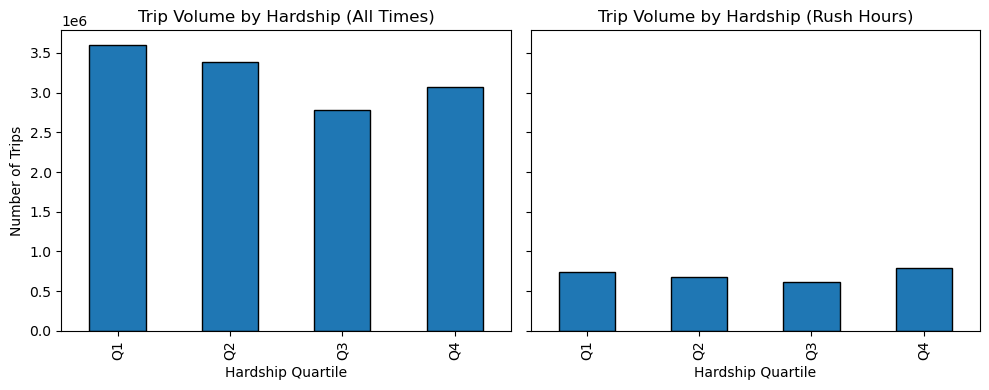

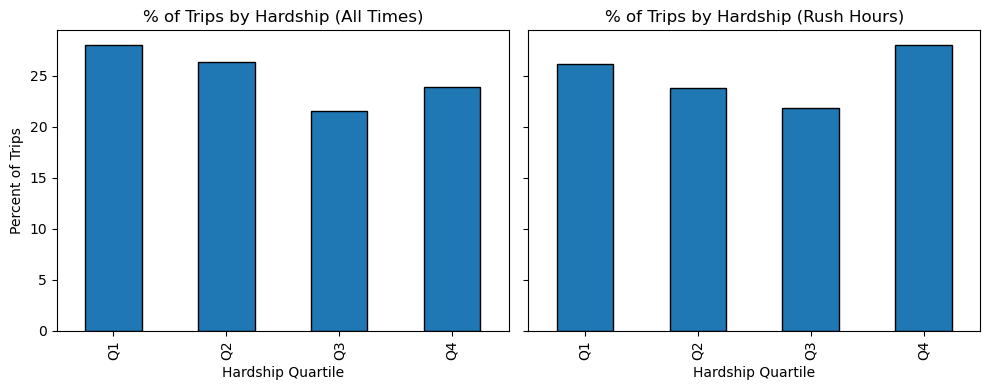

In [52]:


# --- 0) CONFIG ---
HARDSHIP_COL = "pickup_Hardship_index"   

# --- 1) Ensure needed columns exist ---
# a) Hardship quartiles
trips1["hardship_bucket"] = pd.qcut(trips1[HARDSHIP_COL], 4, labels=["Q1","Q2","Q3","Q4"])

# b) start_hour for rush-hour filter
if "start_hour" not in trips1.columns:
    trips1["Trip Start Timestamp"] = pd.to_datetime(trips1["Trip Start Timestamp"])
    trips1["start_hour"] = trips1["Trip Start Timestamp"].dt.hour

# --- 2) Build rush-hour subset ---
rush_trips = trips1[
    ((trips1["start_hour"] >= 6) & (trips1["start_hour"] < 9)) |
    ((trips1["start_hour"] >= 16) & (trips1["start_hour"] < 18))
].copy()

# --- 3) Helper to compute counts + percents ---
def volume_table(df, bucket_col="hardship_bucket", id_col="Trip ID"):
    cnt = df.groupby(bucket_col)[id_col].count().rename("trips").reindex(["Q1","Q2","Q3","Q4"])
    pct = (cnt / cnt.sum() * 100).round(2).rename("percent")
    return pd.concat([cnt, pct], axis=1)

vol_all  = volume_table(trips1)
vol_rush = volume_table(rush_trips)

print("=== Trip volume by hardship (ALL TIMES) ===")
display(vol_all)
print("\n=== Trip volume by hardship (RUSH HOURS 6–9am & 4–6pm) ===")
display(vol_rush)

# --- 4) Plots ---
fig, axes = plt.subplots(1, 2, figsize=(10,4), sharey=True)

vol_all["trips"].plot(kind="bar", ax=axes[0], edgecolor="k")
axes[0].set_title("Trip Volume by Hardship (All Times)")
axes[0].set_xlabel("Hardship Quartile")
axes[0].set_ylabel("Number of Trips")

vol_rush["trips"].plot(kind="bar", ax=axes[1], edgecolor="k")
axes[1].set_title("Trip Volume by Hardship (Rush Hours)")
axes[1].set_xlabel("Hardship Quartile")

plt.tight_layout()
plt.show()

# Percent plots
fig, axes = plt.subplots(1, 2, figsize=(10,4), sharey=True)
vol_all["percent"].plot(kind="bar", ax=axes[0], edgecolor="k")
axes[0].set_title("% of Trips by Hardship (All Times)")
axes[0].set_xlabel("Hardship Quartile")
axes[0].set_ylabel("Percent of Trips")

vol_rush["percent"].plot(kind="bar", ax=axes[1], edgecolor="k")
axes[1].set_title("% of Trips by Hardship (Rush Hours)")
axes[1].set_xlabel("Hardship Quartile")

plt.tight_layout()
plt.show()


=== Trip Volume & Average Fare by Hardship Quartile ===


,trips,avg_fare,percent,context
hardship_bucket,,,,
Q1,3602568,15.336806,28.07,All Times
Q2,3385537,14.841291,26.37,All Times
Q3,2774296,19.548019,21.61,All Times
Q4,3073852,13.498358,23.95,All Times
Q1,743355,17.020652,26.21,Rush Hours
Q2,675523,16.283858,23.82,Rush Hours
Q3,620878,20.139237,21.89,Rush Hours
Q4,795967,14.599191,28.07,Rush Hours


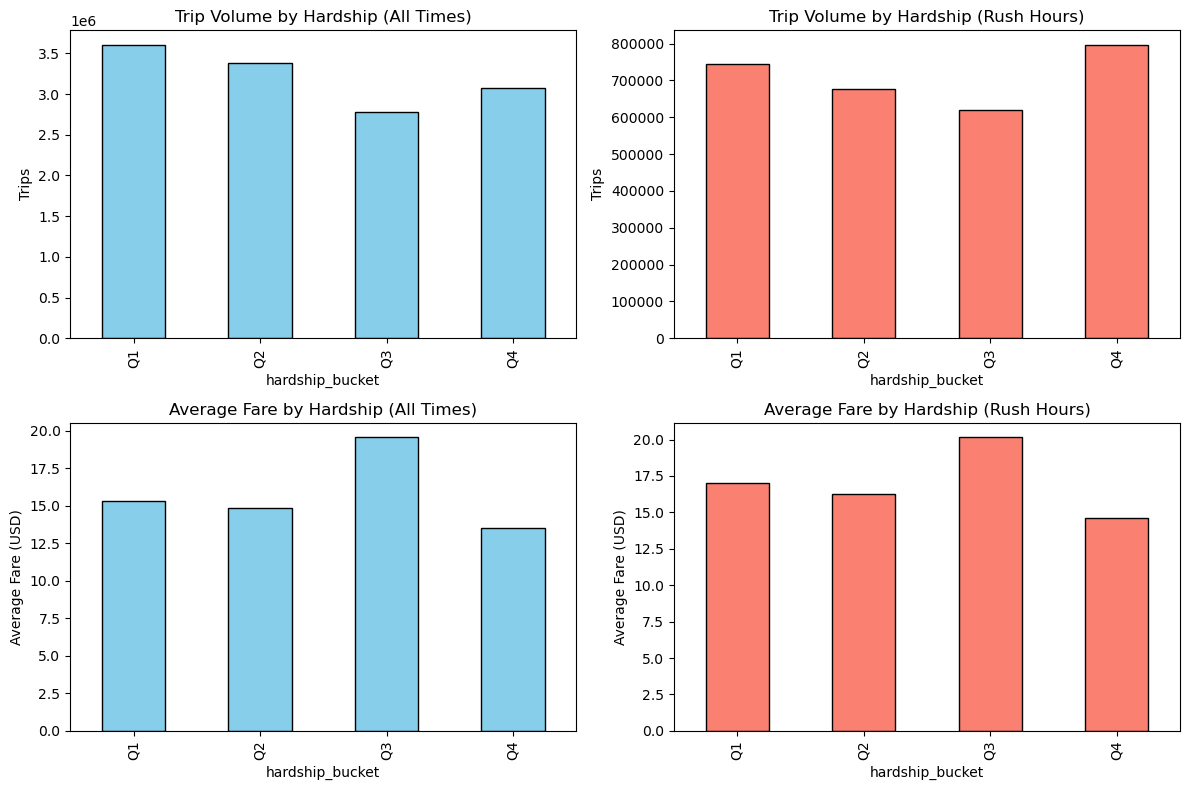

In [54]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Helper: build summary table ---
def hardship_summary(df, label="All Times"):
    tbl = df.groupby("hardship_bucket").agg(
        trips=("Trip ID", "count"),
        avg_fare=("Fare", "mean")
    )
    tbl["percent"] = (tbl["trips"] / tbl["trips"].sum() * 100).round(2)
    tbl["context"] = label
    return tbl

# --- Build summaries ---
summary_all  = hardship_summary(trips1, "All Times")
summary_rush = hardship_summary(rush_trips, "Rush Hours")
summary = pd.concat([summary_all, summary_rush])

print("=== Trip Volume & Average Fare by Hardship Quartile ===")
display(summary)

# --- Plots ---
fig, axes = plt.subplots(2, 2, figsize=(12,8))

# Volume - all times
summary_all["trips"].plot(kind="bar", ax=axes[0,0], color="skyblue", edgecolor="k")
axes[0,0].set_title("Trip Volume by Hardship (All Times)")
axes[0,0].set_ylabel("Trips")

# Volume - rush
summary_rush["trips"].plot(kind="bar", ax=axes[0,1], color="salmon", edgecolor="k")
axes[0,1].set_title("Trip Volume by Hardship (Rush Hours)")
axes[0,1].set_ylabel("Trips")

# Fare - all times
summary_all["avg_fare"].plot(kind="bar", ax=axes[1,0], color="skyblue", edgecolor="k")
axes[1,0].set_title("Average Fare by Hardship (All Times)")
axes[1,0].set_ylabel("Average Fare (USD)")

# Fare - rush
summary_rush["avg_fare"].plot(kind="bar", ax=axes[1,1], color="salmon", edgecolor="k")
axes[1,1].set_title("Average Fare by Hardship (Rush Hours)")
axes[1,1].set_ylabel("Average Fare (USD)")

plt.tight_layout()
plt.show()


#### Based on drop-off location

In [56]:
trips1["dropoff_hardship_bucket"] = pd.qcut(
    trips1["dropoff_Hardship_index"], 
    4, 
    labels=["Q1","Q2","Q3","Q4"]
)


Average Fare by Dropoff Hardship Quartile
dropoff_hardship_bucket
Q1    13.658411
Q2    13.320407
Q3    19.593130
Q4    12.664931
Name: Fare, dtype: float64


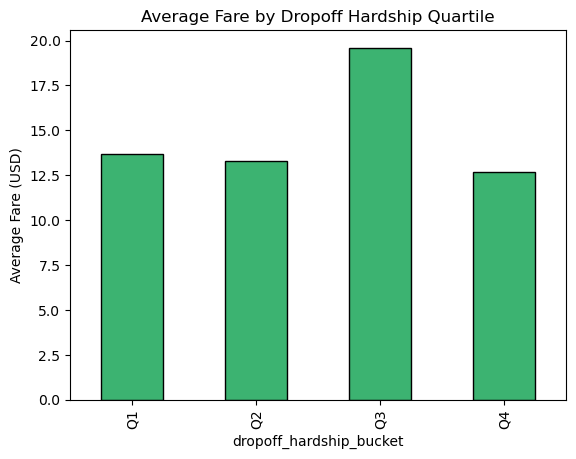

In [58]:
fare_by_dropoff = trips1.groupby("dropoff_hardship_bucket")["Fare"].mean()
print("Average Fare by Dropoff Hardship Quartile")
print(fare_by_dropoff)

fare_by_dropoff.plot(kind="bar", color="mediumseagreen", edgecolor="k")
plt.ylabel("Average Fare (USD)")
plt.title("Average Fare by Dropoff Hardship Quartile")
plt.show()


Percent of Trips by Dropoff Hardship Quartile
dropoff_hardship_bucket
Q1    29.990919
Q2    27.954326
Q3    17.322600
Q4    24.732155
Name: Trip ID, dtype: float64


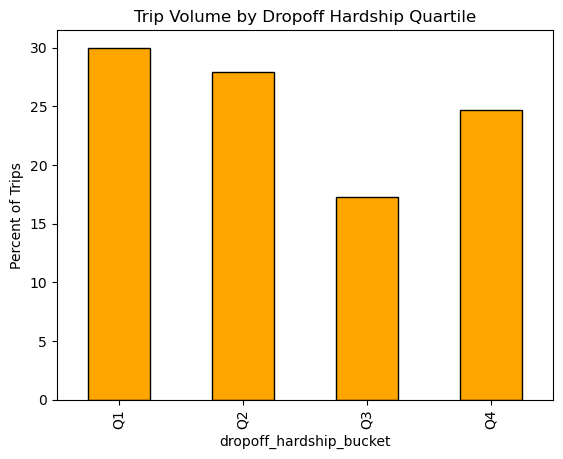

In [60]:
vol_by_dropoff = trips1.groupby("dropoff_hardship_bucket")["Trip ID"].count()
vol_by_dropoff = vol_by_dropoff / vol_by_dropoff.sum() * 100
print("Percent of Trips by Dropoff Hardship Quartile")
print(vol_by_dropoff)

vol_by_dropoff.plot(kind="bar", color="orange", edgecolor="k")
plt.ylabel("Percent of Trips")
plt.title("Trip Volume by Dropoff Hardship Quartile")
plt.show()


In [62]:
import pandas as pd

# --- Create quartiles for pickup and dropoff hardship ---
trips1["pickup_bucket"] = pd.qcut(trips1["pickup_Hardship_index"], 4, labels=["Q1","Q2","Q3","Q4"])
trips1["dropoff_bucket"] = pd.qcut(trips1["dropoff_Hardship_index"], 4, labels=["Q1","Q2","Q3","Q4"])

# --- Helper function for summary ---
def hardship_summary(df, bucket_col, label):
    tbl = df.groupby(bucket_col).agg(
        trips=("Trip ID", "count"),
        avg_fare=("Fare", "mean")
    )
    tbl["percent"] = (tbl["trips"] / tbl["trips"].sum() * 100).round(2)
    tbl["context"] = label
    return tbl

# --- All trips ---
pickup_all  = hardship_summary(trips1, "pickup_bucket", "Pickup - All Times")
dropoff_all = hardship_summary(trips1, "dropoff_bucket", "Dropoff - All Times")

# --- Rush hour trips ---
rush_trips = trips1[
    ((trips1["start_hour"] >= 6) & (trips1["start_hour"] < 9)) |
    ((trips1["start_hour"] >= 16) & (trips1["start_hour"] < 18))
]

pickup_rush  = hardship_summary(rush_trips, "pickup_bucket", "Pickup - Rush Hours")
dropoff_rush = hardship_summary(rush_trips, "dropoff_bucket", "Dropoff - Rush Hours")

# --- Combine into one table ---
summary = pd.concat([pickup_all, dropoff_all, pickup_rush, dropoff_rush])
print("=== Pickup vs Dropoff: Trip Volume & Average Fare by Hardship Quartile ===")
display(summary)


=== Pickup vs Dropoff: Trip Volume & Average Fare by Hardship Quartile ===


,trips,avg_fare,percent,context
Q1,3602568,15.336806,28.07,Pickup - All Times
Q2,3385537,14.841291,26.37,Pickup - All Times
Q3,2774296,19.548019,21.61,Pickup - All Times
Q4,3073852,13.498358,23.95,Pickup - All Times
Q1,3474825,13.658411,29.99,Dropoff - All Times
Q2,3238860,13.320407,27.95,Dropoff - All Times
Q3,2007041,19.593130,17.32,Dropoff - All Times
Q4,2865531,12.664931,24.73,Dropoff - All Times
Q1,743355,17.020652,26.21,Pickup - Rush Hours
Q2,675523,16.283858,23.82,Pickup - Rush Hours


Average Fare per Mile by Pickup Hardship Quartile
pickup_bucket
Q1    7.955578
Q2    6.474064
Q3    4.306663
Q4    4.303218
Name: fare_per_mile, dtype: float64


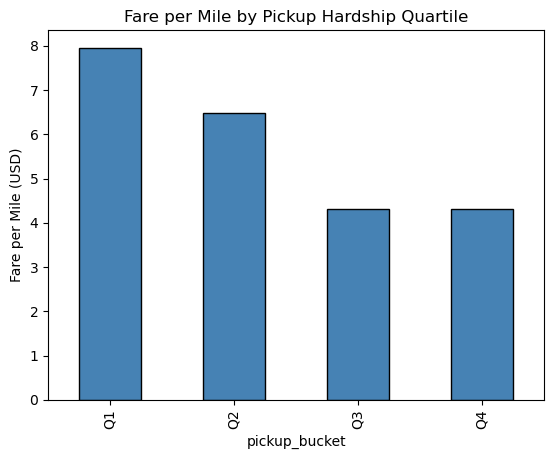

In [64]:
pickup_fpm = trips1.groupby("pickup_bucket")["fare_per_mile"].mean()
print("Average Fare per Mile by Pickup Hardship Quartile")
print(pickup_fpm)

pickup_fpm.plot(kind="bar", color="steelblue", edgecolor="k")
plt.ylabel("Fare per Mile (USD)")
plt.title("Fare per Mile by Pickup Hardship Quartile")
plt.show()


Average Fare per Mile by Dropoff Hardship Quartile
dropoff_bucket
Q1    8.065623
Q2    6.648011
Q3    4.644127
Q4    4.659685
Name: fare_per_mile, dtype: float64


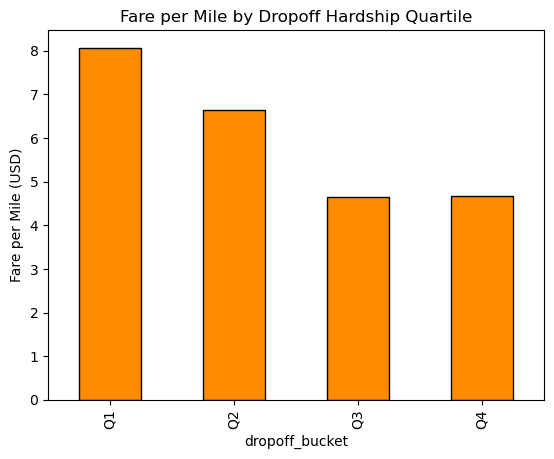

In [66]:
dropoff_fpm = trips1.groupby("dropoff_bucket")["fare_per_mile"].mean()
print("Average Fare per Mile by Dropoff Hardship Quartile")
print(dropoff_fpm)

dropoff_fpm.plot(kind="bar", color="darkorange", edgecolor="k")
plt.ylabel("Fare per Mile (USD)")
plt.title("Fare per Mile by Dropoff Hardship Quartile")
plt.show()


In [68]:
rush_pickup_fpm = rush_trips.groupby("pickup_bucket")["fare_per_mile"].mean()
rush_dropoff_fpm = rush_trips.groupby("dropoff_bucket")["fare_per_mile"].mean()

print("Rush Hour – Fare per Mile by Pickup:")
print(rush_pickup_fpm)
print("\nRush Hour – Fare per Mile by Dropoff:")
print(rush_dropoff_fpm)


Rush Hour – Fare per Mile by Pickup:
pickup_bucket
Q1    8.408591
Q2    6.455407
Q3    4.311170
Q4    4.502863
Name: fare_per_mile, dtype: float64

Rush Hour – Fare per Mile by Dropoff:
dropoff_bucket
Q1    8.056646
Q2    6.776732
Q3    4.566320
Q4    4.961539
Name: fare_per_mile, dtype: float64


In [50]:
from scipy import stats

# --- Group data ---
pickup_groups = [trips1.loc[trips1["pickup_bucket"] == q, "fare_per_mile"].dropna() 
                 for q in ["Q1","Q2","Q3","Q4"]]
dropoff_groups = [trips1.loc[trips1["dropoff_bucket"] == q, "fare_per_mile"].dropna() 
                  for q in ["Q1","Q2","Q3","Q4"]]

# --- ANOVA ---
anova_pickup = stats.f_oneway(*pickup_groups)
anova_dropoff = stats.f_oneway(*dropoff_groups)

# --- Kruskal–Wallis ---
kruskal_pickup = stats.kruskal(*pickup_groups)
kruskal_dropoff = stats.kruskal(*dropoff_groups)

print("=== Pickup Hardship Quartiles ===")
print("ANOVA:", anova_pickup)
print("Kruskal–Wallis:", kruskal_pickup)

print("\n=== Dropoff Hardship Quartiles ===")
print("ANOVA:", anova_dropoff)
print("Kruskal–Wallis:", kruskal_dropoff)


=== Pickup Hardship Quartiles ===
ANOVA: F_onewayResult(statistic=382575.91243252024, pvalue=0.0)
Kruskal–Wallis: KruskalResult(statistic=1681121.9987438328, pvalue=0.0)

=== Dropoff Hardship Quartiles ===
ANOVA: F_onewayResult(statistic=277211.23533551116, pvalue=0.0)
Kruskal–Wallis: KruskalResult(statistic=1186601.8290027878, pvalue=0.0)


### Top 8 pick-up areas by hardship and Top 15 highest Avg fare areas

In [70]:
import pandas as pd
import numpy as np

# ================================
# CONFIG
# ================================
TOP_N = 8           # how many areas to show per bucket
USE_RUSH = True     # True → rush hours (6–9am, 4–6pm); False → all times
SIDE = "pickup"     # "pickup" or "dropoff"
HARDSHIP_COL = f"{SIDE}_Hardship_index"
AREA_ID_COL   = f"{SIDE.capitalize()} Community Area"  # "Pickup Community Area" or "Dropoff Community Area"
AREA_NAME_COL = "Community Area"  # if you have a clean name field aligned to AREA_ID_COL; if not, this will be blank

# ================================
# PREP
# ================================
# Buckets (quartiles) for the chosen SIDE
trips1[f"{SIDE}_bucket"] = pd.qcut(trips1[HARDSHIP_COL], 4, labels=["Q1","Q2","Q3","Q4"])

# Rush-hour filter (optional)
if "start_hour" not in trips1.columns:
    trips1["Trip Start Timestamp"] = pd.to_datetime(trips1["Trip Start Timestamp"])
    trips1["start_hour"] = trips1["Trip Start Timestamp"].dt.hour

if USE_RUSH:
    df = trips1[
        ((trips1["start_hour"] >= 6) & (trips1["start_hour"] < 9)) |
        ((trips1["start_hour"] >= 16) & (trips1["start_hour"] < 18))
    ].copy()
    context_label = "Rush Hours (6–9am, 4–6pm)"
else:
    df = trips1.copy()
    context_label = "All Times"

bucket_col = f"{SIDE}_bucket"

# ================================
# BUILD PER-AREA SUMMARY WITHIN BUCKETS
# ================================

group_cols = [bucket_col, AREA_ID_COL]
if AREA_NAME_COL in df.columns:
    group_cols.append(AREA_NAME_COL)

agg = df.groupby(group_cols).agg(
    hardship_mean=(HARDSHIP_COL, "mean"),
    trips=("Trip ID", "count"),
    avg_fare=("Fare", "mean"),
    fare_per_mile=("fare_per_mile", "mean")
).reset_index()

# % share within each bucket
agg["bucket_trips"] = agg.groupby(bucket_col)["trips"].transform("sum")
agg["pct_in_bucket"] = 100 * agg["trips"] / agg["bucket_trips"]

# rank areas within each bucket by trips
agg["rank_in_bucket"] = agg.groupby(bucket_col)["trips"].rank(method="first", ascending=False)

# keep top N per bucket
topN = agg[agg["rank_in_bucket"] <= TOP_N].copy()

# tidy formatting
show_cols = [bucket_col, "rank_in_bucket", AREA_ID_COL]
if AREA_NAME_COL in topN.columns:
    show_cols.append(AREA_NAME_COL)
show_cols += ["hardship_mean", "trips", "pct_in_bucket", "avg_fare", "fare_per_mile"]

topN = (topN[show_cols]
        .sort_values([bucket_col, "rank_in_bucket"])
        .rename(columns={
            bucket_col: "Hardship Quartile",
            AREA_ID_COL: "Area ID",
            AREA_NAME_COL: "Area Name",
            "hardship_mean": "Hardship (avg)",
            "trips": "Trips",
            "pct_in_bucket": "% within quartile",
            "avg_fare": "Avg Fare",
            "fare_per_mile": "Fare per Mile"
        }))

print(f"\n=== Top {TOP_N} {SIDE.title()} Areas per Hardship Quartile — {context_label} ===")
display(topN.round({
    "Hardship (avg)": 1, "% within quartile": 2, "Avg Fare": 2, "Fare per Mile": 2
}))

# ================================
# OPTIONAL: FOCUS VIEW ON "ISSUE" AREAS
# ================================
focus_quartile = "Q3"
focus = (agg[agg[bucket_col] == focus_quartile]
         .sort_values(["avg_fare", "trips"], ascending=[False, False])
         .head(15))

focus_cols = [AREA_ID_COL]
if AREA_NAME_COL in focus.columns:
    focus_cols.append(AREA_NAME_COL)
focus_cols += ["hardship_mean", "trips", "avg_fare", "fare_per_mile", "pct_in_bucket"]

focus_pretty = (focus[focus_cols]
                .rename(columns={
                    AREA_ID_COL: "Area ID",
                    AREA_NAME_COL: "Area Name",
                    "hardship_mean": "Hardship (avg)",
                    "trips": "Trips",
                    "avg_fare": "Avg Fare",
                    "fare_per_mile": "Fare per Mile",
                    "pct_in_bucket": "% within Q3"
                }))

print(f"\n=== Focus: Top 15 {SIDE.title()} Areas within {focus_quartile} by Avg Fare — {context_label} ===")
display(focus_pretty.round({"Hardship (avg)":1, "Avg Fare":2, "Fare per Mile":2, "% within Q3":2}))



=== Top 8 Pickup Areas per Hardship Quartile — Rush Hours (6–9am, 4–6pm) ===


,Hardship Quartile,rank_in_bucket,Area ID,Area Name,Hardship (avg),Trips,% within quartile,Avg Fare,Fare per Mile
586,Q1,1.0,8,Near North Side,1.0,392252,52.77,16.77,8.69
2428,Q1,2.0,32,Loop,3.0,227097,30.55,17.40,8.94
500,Q1,3.0,7,Lincoln Park,2.0,124006,16.68,17.13,6.56
0,Q1,4.0,1,Albany Park,NaN,0,0.00,NaN,NaN
1,Q1,5.0,1,Archer Heights,NaN,0,0.00,NaN,NaN
2,Q1,6.0,1,Armour Square,NaN,0,0.00,NaN,NaN
3,Q1,7.0,1,Ashburn,NaN,0,0.00,NaN,NaN
4,Q1,8.0,1,Auburn Gresham,NaN,0,0.00,NaN,NaN
8057,Q2,1.0,28,Near West Side,15.0,219817,32.54,15.20,7.31
6351,Q2,2.0,6,Lake View,5.0,157682,23.34,17.56,5.88



=== Focus: Top 15 Pickup Areas within Q3 by Avg Fare — Rush Hours (6–9am, 4–6pm) ===


,Area ID,Area Name,Hardship (avg),Trips,Avg Fare,Fare per Mile,% within Q3
17689,76,Ohare,24.0,119045,35.09,3.06,19.17
16120,56,Garfield Ridge,32.0,40071,29.44,3.77,6.45
17731,77,Edgewater,19.0,47620,16.56,4.59,7.67
17525,74,Mount Greenwood,16.0,3232,16.54,4.07,0.52
12078,3,Uptown,20.0,62424,16.09,4.98,10.05
14820,39,Kenwood,26.0,16587,16.03,4.99,2.67
12128,4,Lincoln Square,17.0,32206,15.98,4.84,5.19
11918,1,Rogers Park,39.0,43011,15.85,4.68,6.93
13515,22,Logan Square,23.0,79447,15.80,5.28,12.80
15490,48,Calumet Heights,38.0,6374,15.28,4.37,1.03


### Creating choropleth maps of Chicago’s 77 community areas

In [74]:
import pandas as pd

# One hardship value per community area
area_hardship = (
    trips1.groupby("Pickup Community Area")["pickup_Hardship_index"]
          .max()                 
          .rename("hardship_index")
          .reset_index()
          .rename(columns={"Pickup Community Area":"community_area_number"})
)



In [76]:
import geopandas as gpd
print(gpd.__version__)

1.1.1


In [80]:
COMMUNITY_AREAS_PATH = "C:/Users/Documents/ERP/Data/Boundaries_Community_Areas_20250827.geojson" 

gdf = gpd.read_file(COMMUNITY_AREAS_PATH)

# Make sure area number is integer and named consistently
if "area_num_1" in gdf.columns:
    gdf["community_area_number"] = gdf["area_num_1"].astype(int)
elif "area_numbe" in gdf1.columns:
    gdf["community_area_number"] = gdf["area_numbe"].astype(int)


# Merge hardship onto geometry (left join keeps all 77)
gdf = gdf.merge(area_hardship, on="community_area_number", how="left")


In [123]:

# A) Area-level quartiles (77 values)
gdf["hardship_bucket_area"] = pd.qcut(
    gdf["hardship_index"], q=4, labels=["Q1","Q2","Q3","Q4"]
)

# B) Trip-weighted quartiles (derive cutpoints from trips)
trip_cuts = pd.qcut(trips1["pickup_Hardship_index"], q=4, retbins=True, labels=["Q1","Q2","Q3","Q4"])[1]
gdf["hardship_bucket_tripweighted"] = pd.cut(
    gdf["hardship_index"], bins=trip_cuts, labels=["Q1","Q2","Q3","Q4"], include_lowest=True
)


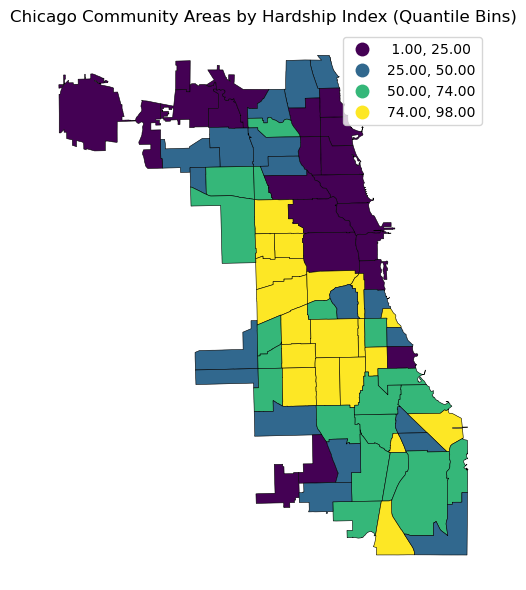

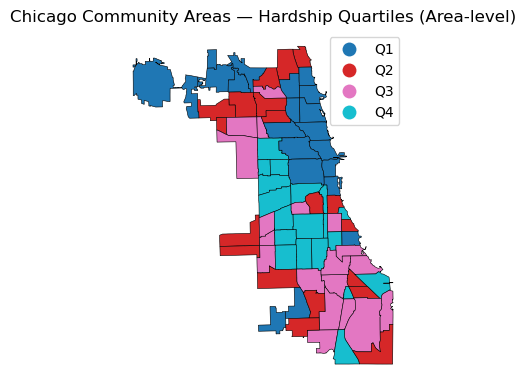

In [127]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
# Simple quantile choropleth by hardship (continuous)
gdf.plot(column="hardship_index", scheme="quantiles", k=4, legend=True, linewidth=0.4, edgecolor="black", ax=ax)

ax.set_axis_off()
ax.set_title("Chicago Community Areas by Hardship Index (Quantile Bins)")
plt.tight_layout()
plt.show()


fig, ax = plt.subplots(1, 1, figsize=(4,4))
gdf.plot(column="hardship_bucket_area", legend=True, linewidth=0.4, edgecolor="black", ax=ax)
ax.set_axis_off()
ax.set_title("Chicago Community Areas — Hardship Quartiles (Area-level)")
plt.tight_layout()
plt.show()
